In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout , Conv1D, MaxPooling1D, Flatten, Input, concatenate


warnings.filterwarnings("ignore")

2024-07-06 02:26:14.303892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 02:26:14.304040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 02:26:14.447162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# --- 1. Load and Prepare Data ---
# Define the file path
file_path = '/kaggle/input/amazon-customer-reviews/Reviews.csv'

df = pd.read_csv(file_path)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
df.shape

(568454, 10)

In [6]:
# Drop specified columns
columns_to_drop = ['ProductId', 'Id', 'ProfileName', 'UserId', 'HelpfulnessDenominator', 'HelpfulnessNumerator', 'Time']
df.drop(columns=columns_to_drop, inplace=True)


In [7]:
# Verify the columns are dropped
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [9]:
# Combine 'summary' and 'text' into a single feature, ensuring all text is properly handled
df['Summary'] = df['Summary'].fillna('').astype(str)
df['Text'] = df['Text'].fillna('').astype(str)
df['Combined_text'] = df['Summary'] + " " + df['Text']

In [10]:
# --- 2. Preprocess Text Data ---
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['Combined_text'])
sequences = tokenizer.texts_to_sequences(df['Combined_text'])
word_index = tokenizer.word_index

In [11]:
# Pad sequences to ensure uniform input size
max_length = 300
data = pad_sequences(sequences, maxlen=max_length)
data.shape

(568454, 300)

In [12]:
y_dict = {1:0, 2:0, 3:1, 4:1, 5:1}
y = df['Score'].map(y_dict)
y

0         1
1         0
2         1
3         0
4         1
         ..
568449    1
568450    0
568451    1
568452    1
568453    1
Name: Score, Length: 568454, dtype: int64

In [13]:
# --- 3. Handle Class Imbalance and Encode Labels ---
df['Score'] = df['Score'].fillna(df['Score'].mode()[0])
print("Class distribution before oversampling:", Counter(y))

ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data, y)

print("Class distribution after oversampling:", Counter(labels_resampled))

Class distribution before oversampling: Counter({1: 486417, 0: 82037})
Class distribution after oversampling: Counter({1: 486417, 0: 486417})


In [14]:
# Encode labels (after oversampling)
label_encoder = LabelEncoder()
labels_resampled = label_encoder.fit_transform(labels_resampled)
labels_resampled = to_categorical(labels_resampled, num_classes=2)

In [15]:
# --- 4. Train-Test Split ---
x_train, x_val, y_train, y_val = train_test_split(
    data_resampled, labels_resampled, test_size=0.2, random_state=42
)

In [16]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (778267, 300)
x_val shape: (194567, 300)
y_train shape: (778267, 2)
y_val shape: (194567, 2)


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Define hyperparameters
vocab_size = len(word_index) + 1  # Adding 1 to account for the padding token
embedding_dim = 100  # Size of the embedding vectors
max_length = 300  # Maximum length of input sequences

# Input layer for the text data
input_text = Input(shape=(max_length,))

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_text)

# CNN branch
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding)
conv1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(conv1)
conv2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(filters=128, kernel_size=7, activation='relu')(conv2)
conv3 = MaxPooling1D(pool_size=2)(conv3)
conv_out = Flatten()(conv3)

# Fully connected layers
dense1 = Dense(256, activation='relu')(conv_out)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Output layer
outputs = Dense(2, activation='sigmoid')(dropout2)

# Model
model = Model(inputs=input_text, outputs=outputs)

# Compile the model with MSE as an additional metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 100)       │    13,951,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 298, 128)       │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 149, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 145, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 66, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 33, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4224)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,081,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,301,246 (58.37 MB)

 Trainable params: 15,301,246 (58.37 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# --- 8. Train the Model ---
import time
# Start time measurement
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))

# End time measurement
end_time = time.time()

# Calculate total time
print(f"Total training time: {end_time - start_time:.4f} seconds")

Epoch 1/5
   21/24321 ━━━━━━━━━━━━━━━━━━━━ 3:20 8ms/step - accuracy: 0.4822 - loss: 0.6945

I0000 00:00:1720232918.079606     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24321/24321 ━━━━━━━━━━━━━━━━━━━━ 213s 8ms/step - accuracy: 0.9140 - loss: 0.2159 - val_accuracy: 0.9622 - val_loss: 0.1175
Epoch 2/5
   15/24321 ━━━━━━━━━━━━━━━━━━━━ 3:04 8ms/step - accuracy: 0.9512 - loss: 0.1141

W0000 00:00:1720233120.119559     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24321/24321 ━━━━━━━━━━━━━━━━━━━━ 196s 8ms/step - accuracy: 0.9692 - loss: 0.0962 - val_accuracy: 0.9722 - val_loss: 0.0867
Epoch 3/5
24321/24321 ━━━━━━━━━━━━━━━━━━━━ 197s 8ms/step - accuracy: 0.9801 - loss: 0.0654 - val_accuracy: 0.9740 - val_loss: 0.0819
Epoch 4/5
24321/24321 ━━━━━━━━━━━━━━━━━━━━ 197s 8ms/step - accuracy: 0.9854 - loss: 0.0494 - val_accuracy: 0.9796 - val_loss: 0.0814
Epoch 5/5
24321/24321 ━━━━━━━━━━━━━━━━━━━━ 199s 8ms/step - accuracy: 0.9885 - loss: 0.0397 - val_accuracy: 0.9818 - val_loss: 0.0912
Total training time: 1004.9359 seconds


In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Accuracy: {accuracy}')

6081/6081 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9820 - loss: 0.0897
Validation Accuracy: 0.9817646145820618


In [21]:
# Example prediction
new_texts = ["This product is excellent.", "Not what I expected."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_data = pad_sequences(new_sequences, maxlen=max_length)

predictions = model.predict(new_data)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))
print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
[0 0]


W0000 00:00:1720234098.001674     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [22]:
# Predict on the validation set
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

6081/6081 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


W0000 00:00:1720234116.649121     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# Calculate metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred_classes))



Accuracy: 0.9817646363463486
Precision: 0.9819400827311056
Recall: 0.9817646363463486
F1 Score: 0.9817629920709305

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     97275
           1       0.99      0.97      0.98     97292

    accuracy                           0.98    194567
   macro avg       0.98      0.98      0.98    194567
weighted avg       0.98      0.98      0.98    194567



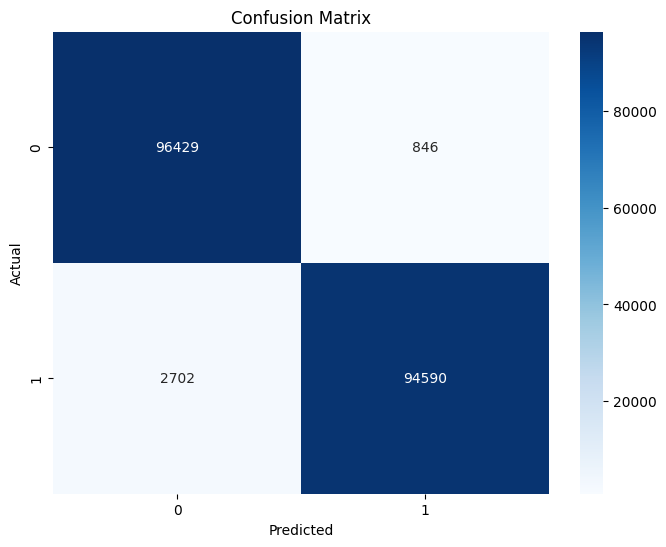

In [24]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()